In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC

2024-04-16 21:00:20.601663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
trip = pd.read_csv("../data/clean/trip.csv")

# Drop any columns with the string "id" or "flag" in them
for col in trip:
  if "id" in col:
    trip = trip.drop(col, axis=1)

# Drop these columns: 'reason_for_travel_to', 'why_trip', 'trip_purpose_old_schema'
trip = trip.drop(['trip_purpose_old_schema', 'why_trip', 'reason_for_travel_to'], axis=1)

# Prepare trip data for model
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

for col in trip.columns.drop('trip_purpose'):
  if trip[col].dtype == object:
    trip[col] = label_encoder.fit_transform(trip[col])
  else: # Normalize
    trip[col] = scaler.fit_transform(trip[col].values.reshape(-1, 1))

# Remove rows where trip purpose is "Not Ascertained"
trip = trip[trip["trip_purpose"] != "Not ascertained"]
trip = trip.reset_index(drop=True)

vis = trip["trip_purpose"].astype('category')

trip["trip_purpose"] = label_encoder.fit_transform(trip["trip_purpose"])
target = trip["trip_purpose"].to_numpy()
features = trip.drop('trip_purpose', axis=1).to_numpy()

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [3]:
# Create validation data as 10% of training data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

# Create LSTM model
model = keras.Sequential()
model.add(layers.Input(shape=(features.shape[1],)))
# add convolutional layer
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=32,
    callbacks=keras.callbacks.EarlyStopping(patience=2),
    validation_data=(x_val, y_val)
)

predictions = model.predict(x_test, verbose=0)
NN_preds = np.argmax(predictions, axis=1)
loss, NN_accuracy = model.evaluate(x_test, y_test, verbose=0)


Epoch 1/500
699/699 [==============================] - 1s 1ms/step - loss: 1.3774 - accuracy: 0.3832 - val_loss: 1.3051 - val_accuracy: 0.4300
Epoch 2/500
699/699 [==============================] - 1s 1ms/step - loss: 1.2169 - accuracy: 0.4654 - val_loss: 1.1813 - val_accuracy: 0.4758
Epoch 3/500
699/699 [==============================] - 1s 1ms/step - loss: 1.1204 - accuracy: 0.4941 - val_loss: 1.0825 - val_accuracy: 0.5193
Epoch 4/500
699/699 [==============================] - 1s 1ms/step - loss: 1.0760 - accuracy: 0.5135 - val_loss: 1.0599 - val_accuracy: 0.5229
Epoch 5/500
699/699 [==============================] - 1s 1ms/step - loss: 1.0431 - accuracy: 0.5222 - val_loss: 1.0359 - val_accuracy: 0.5254
Epoch 6/500
699/699 [==============================] - 1s 1ms/step - loss: 1.0223 - accuracy: 0.5288 - val_loss: 1.0099 - val_accuracy: 0.5177
Epoch 7/500
699/699 [==============================] - 1s 1ms/step - loss: 0.9982 - accuracy: 0.5423 - val_loss: 0.9897 - val_accuracy: 0.5366

In [4]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_model = LogisticRegression()

grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
logit_pred = best_model.predict(x_test)
y_pred = best_model.predict(x_test)
Logit_accuracy = accuracy_score(y_test, y_pred)

/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aaron/opt/anaconda3/lib/python3.9/site-pack

In [5]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

model1 = xgb.XGBClassifier()
grid_search = RandomizedSearchCV(estimator=model1, param_distributions=param_grid, n_iter=20, scoring='accuracy', cv=3)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

xgboost_model = xgb.XGBClassifier(**best_params)
xgboost_model.fit(x_train, y_train)

agboost_pred = xgboost_model.predict(x_test)
xgboost_accuracy = accuracy_score(y_test, agboost_pred)

In [6]:
best_c = 10
best_kernel = "poly"
svc = SVC(C=best_c, kernel=best_kernel)
svc.fit(x_train, y_train)

SVM_pred = svc.predict(x_test)
svm_accuracy = accuracy_score(y_test, SVM_pred)

195/195 [==============================] - 0s 958us/step


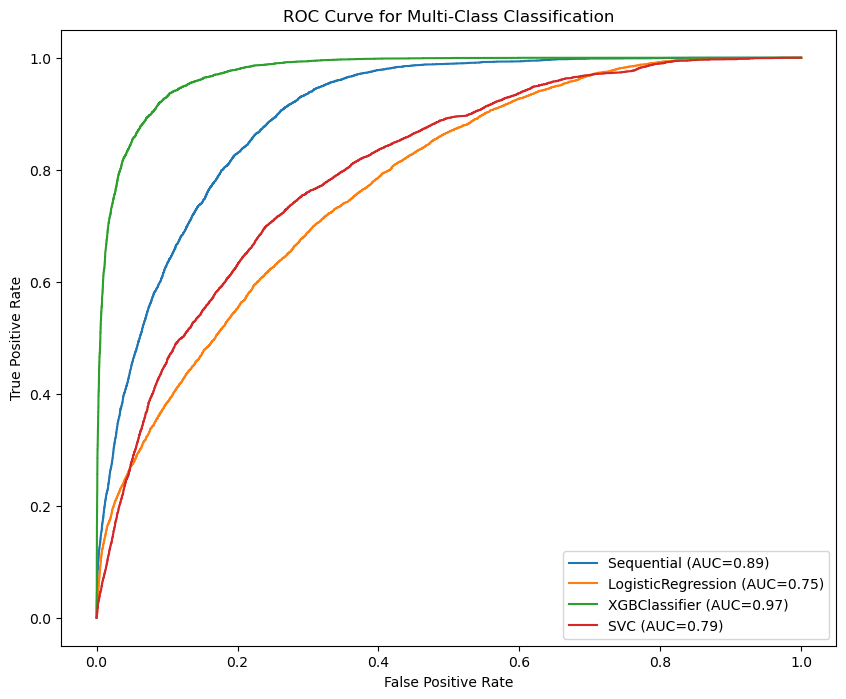

In [13]:
from sklearn.preprocessing import label_binarize

models = [model, best_model, xgboost_model, svc]
fig, ax = plt.subplots(figsize=(10, 8))
for mod in models:
    y_test_binary = label_binarize(y_test, classes=np.unique(y_test))
    if hasattr(mod, 'predict_proba'):
        y_pred_proba = mod.predict_proba(x_test)
    elif hasattr(mod, 'decision_function'):
        y_pred_proba = mod.decision_function(x_test)
    else:
        y_pred_proba = model.predict(x_test)
    fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred_proba.ravel())
    roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{type(mod).__name__} (AUC={roc_auc:.2f})")

ax.set_title('ROC Curve for Multi-Class Classification')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

In [8]:
print(f"NN Accuracy: {NN_accuracy}")
print(f"Logistic regression accuracy: {Logit_accuracy}")
print(f"Xgboost accuracy: {xgboost_accuracy}")
print(f"SVM accuracy: {svm_accuracy}")

NN Accuracy: 0.6101449131965637
Logistic regression accuracy: 0.4396135265700483
Xgboost accuracy: 0.8293075684380032
SVM accuracy: 0.5045088566827697
